<a href = "https://www.pieriantraining.com"><img src="../PT Centered Purple.png"> </a>

<em style="text-align:center">Copyrighted by Pierian Training</em>

# Image Generation
In this notebook we are going to inspect how to use AWS Bedrock to generate images leveraging Stability AI!

## API Connection
Let's directly use the bedrock runtime

In [1]:
import boto3
import json
bedrock_runtime = boto3.client(aws_access_key_id="",
                               aws_secret_access_key="",
                               region_name="us-east-1",
                               service_name='bedrock-runtime')


### Stability.ai Diffusion Parameters
Stability.ai Diffusion 1.0 accept the following [parameters](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-diffusion-1-0-text-image.html):

- **text_prompts** (Required)
  - An array of text prompts for generation.
  - Each element is a JSON object containing:
    - `text`: The prompt for the model.
      - **Minimum**: 0
      - **Maximum**: 2000
    - `weight` (Optional): Weight for the prompt.
      - Less than zero for a negative prompt. A negative prompt tells the model to avoid certain concepts.
      - **Default**: 1
- **cfg_scale** (Optional)
  - Determines the portrayal of the prompt in the final image.
  - Use lower number for increased randomness.
  - **Minimum**: 0
  - **Maximum**: 35
  - **Default**: 7
- **clip_guidance_preset** (Optional)
  - Enum: FAST_BLUE, FAST_GREEN, NONE, SIMPLE SLOW, SLOWER, SLOWEST.
- **height** (Optional)
  - Height of the generated image in pixels, divisible by 64.
  - Valid values: 1024x1024, 1152x896, 1216x832, 1344x768, 1536x640, 640x1536, 768x1344, 832x1216, 896x1152.
  - **Default**: 512
- **width** (Optional)
  - Width of the generated image in pixels, divisible by 64.
  - Valid values: 1024x1024, 1152x896, 1216x832, 1344x768, 1536x640, 640x1536, 768x1344, 832x1216, 896x1152.
  - **Default**: 512
- **sampler** (Optional)
  - The sampler for the diffusion process.
  - Enum: DDIM, DDPM, K_DPMPP_2M, K_DPMPP_2S_ANCESTRAL, K_DPM_2, K_DPM_2_ANCESTRAL, K_EULER, K_EULER_ANCESTRAL, K_HEUN, K_LMS.
  - Automatically selected if omitted.
- **samples** (Optional)
  - Number of images to generate.
  - Currently supports generating one image.
  - **Default**: 1
  - **Minimum**: 1
  - **Maximum**: 1
- **seed** (Optional)
  - Determines initial noise setting.
  - Same seed and settings for similar image generation.
  - Random number if unset or 0.
  - **Minimum**: 0
  - **Maximum**: 4294967295
  - **Default**: 0
- **steps** (Optional)
  - Generation step for image sampling.
  - More steps for more accurate results.
  - **Minimum**: 10
  - **Maximum**: 50
  - **Default**: 30
- **style_preset** (Optional)
  - A style preset guiding the image model.
  - Enum: 3d-model, analog-film, anime, cinematic, comic-book, digital-art, enhance, fantasy-art, isometric, line-art, low-poly, modeling-compound, neon-punk, origami, photographic, pixel-art, tile-texture. **Will change in the future**
- **extras** (Optional)
  - Extra parameters for the engine.
  - Used for in-development or experimental features.
  - Subject to change without warning.
   
Thus, the model expects the following jsonified request body:
```
{
        "text_prompts": [
            {
                "text": string,
                "weight": float
            }
        ],
        "height": int,
        "width": int,
        "cfg_scale": float,
        "clip_guidance_preset": string,
        "sampler": string,
        "samples",
        "seed": int,
        "steps": int,
        "style_preset": string,
        "extras" :JSON object
        
}
```



Let's generate a photorealistic image of an apple using `stability.stable-diffusion-xl-v1` and different cfg_scales!

In [4]:
prompt = "A photorealistic image of an apple."

In [5]:
request_body = json.dumps({
        "text_prompts": [
        {
        "text": prompt
        }
    ],
    "cfg_scale": 1,  # Very low cfg_scale
    "seed": 0,  # Use a seed for reproducability
    "samples" : 1,
    })

In [6]:
response = bedrock_runtime.invoke_model(body=request_body, modelId="stability.stable-diffusion-xl-v1")

In [7]:
response_body = json.loads(response.get('body').read())

Before inspecting the image, let's quickly look at the response structure:

- **result**
  - Outcome of the operation.
  - `success` if the operation is successful.
- **artifacts**
  - An array of images.
  - One image for each requested image.
- **seed**
  - The value of the seed used for generating the image.
- **base64**
  - The base64 encoded image generated by the model.
- **finishedReason**
  - Outcome of the image generation process.
  - Valid values:
    - `SUCCESS`: Image generation process succeeded.
    - `ERROR`: An error occurred.
    - `CONTENT_FILTERED`: Image filtered by the content filter, possibly blurred.

To view the generated image we need to convert the base64 encoded image to a png first:

1. Convert it to a base64 binary string
2. Write this binary data to a png
3. Read the Image to visualize it

In [10]:
import base64
from PIL import Image

In [13]:
base64_image_data = base64.b64decode(response_body["artifacts"][0]["base64"])

In [14]:
file_path = "image.png"
with open(file_path, "wb") as file:
    file.write(base64_image_data)



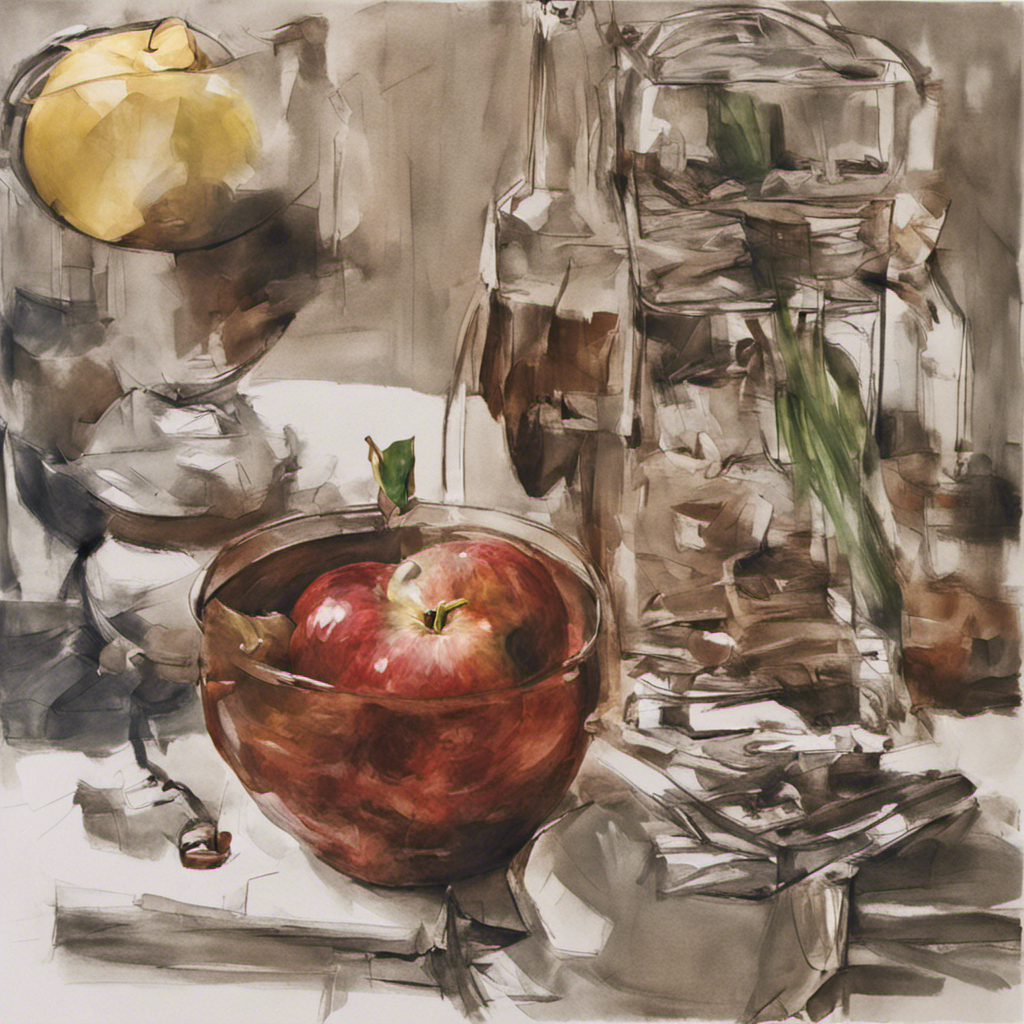

In [15]:
Image.open("image.png")

Well, we can certainly see an apple. However it does not look like the photorealistic part of the prompt has been captured!
Let's try again with a much higher cfg_scale

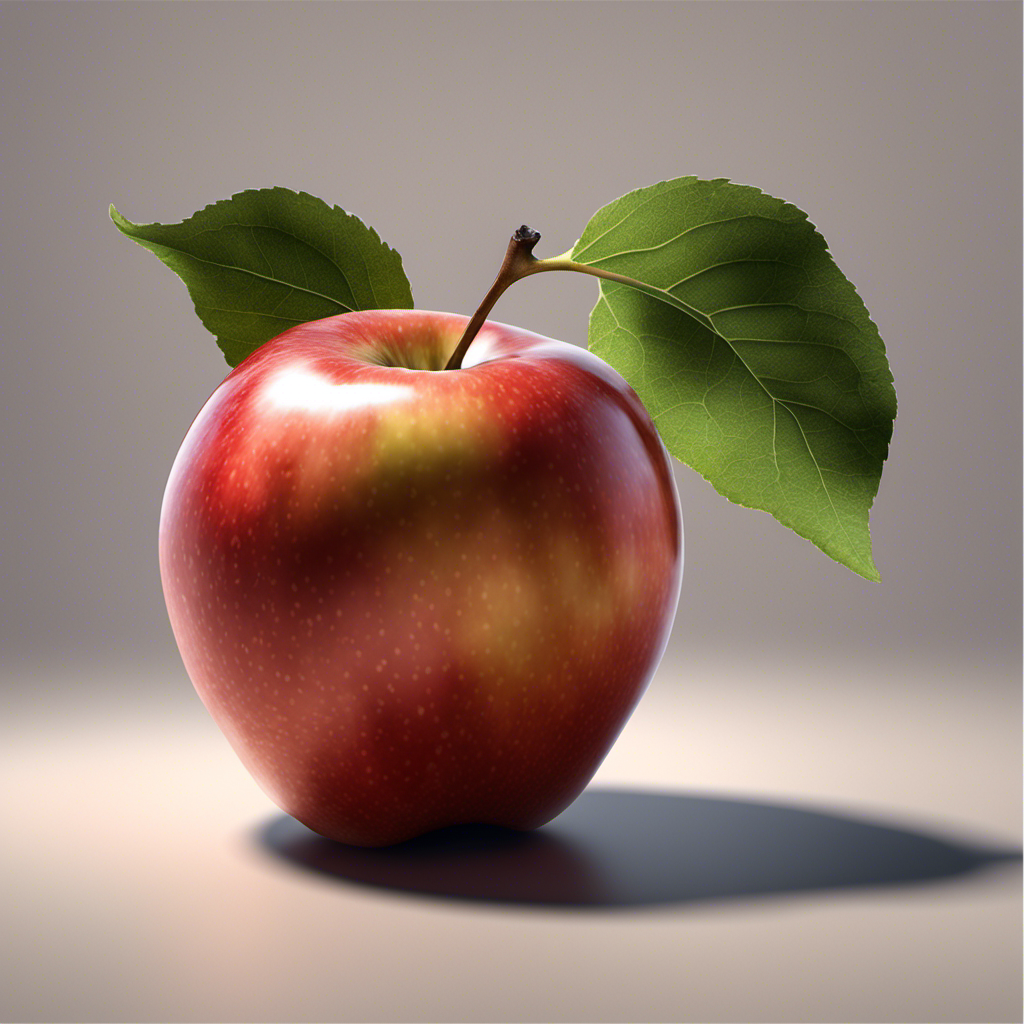

In [18]:
request_body = json.dumps({
        "text_prompts": [
        {
        "text": prompt
        }
    ],
    "cfg_scale": 20,  # High cfg_scale
    "seed": 0,  # Use a seed for reproducability
    "samples" : 1,
    })

response_high_cfg = bedrock_runtime.invoke_model(body=request_body, modelId="stability.stable-diffusion-xl-v1")
response_body_high_cfg = json.loads(response_high_cfg.get('body').read())
base64_image_data_high_cfg = base64.b64decode(response_body_high_cfg["artifacts"][0]["base64"])

file_path = "image2.png"
with open(file_path, "wb") as file:
    file.write(base64_image_data_high_cfg)

Image.open("image2.png")

Cool! This looks much more like an apple!

Last but not least, let's check if the seed actually works and creates the same image again:

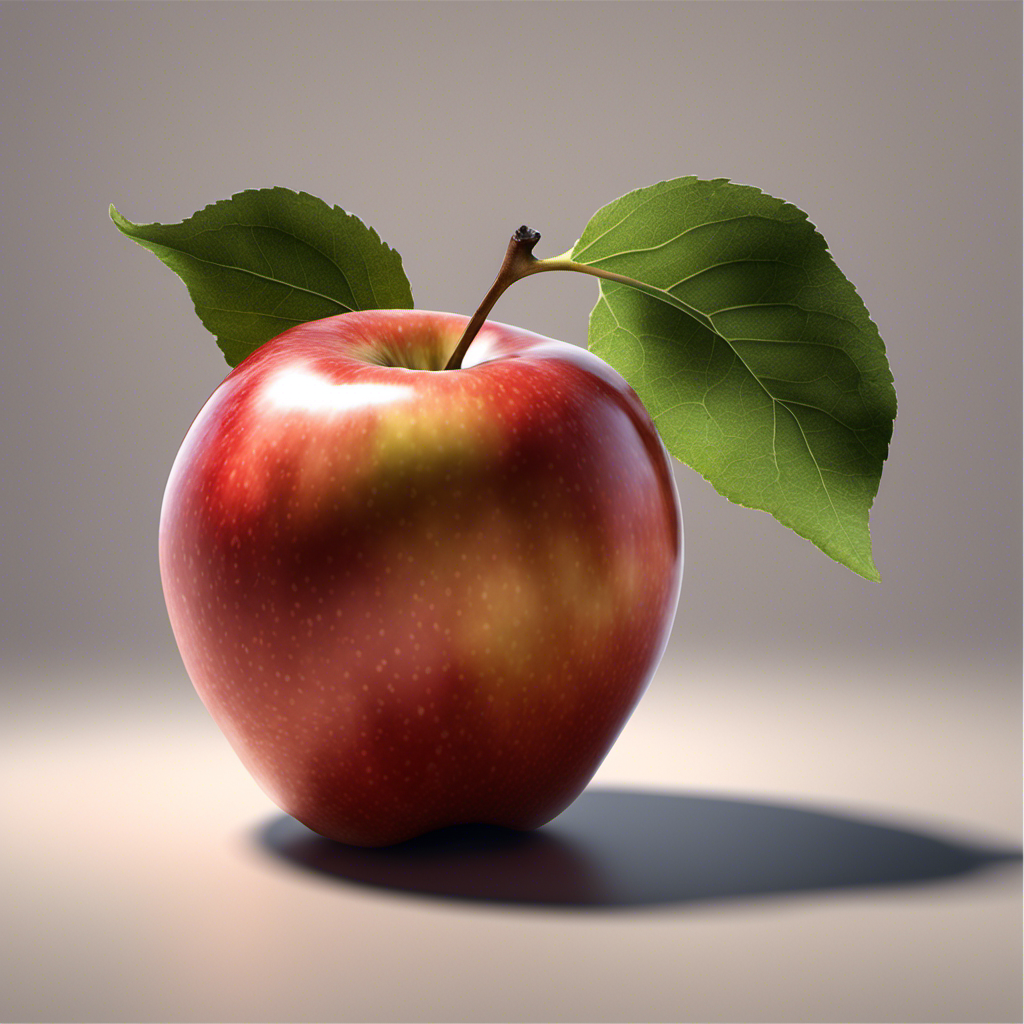

In [19]:
# Just copy the above code and change the image name

request_body = json.dumps({
        "text_prompts": [
        {
        "text": prompt
        }
    ],
    "cfg_scale": 20,  # High cfg_scale
    "seed": 0,  # Use a seed for reproducability
    "samples" : 1,
    })

response_high_cfg = bedrock_runtime.invoke_model(body=request_body, modelId="stability.stable-diffusion-xl-v1")
response_body_high_cfg = json.loads(response_high_cfg.get('body').read())
base64_image_data_high_cfg = base64.b64decode(response_body_high_cfg["artifacts"][0]["base64"])

file_path = "image3.png"
with open(file_path, "wb") as file:
    file.write(base64_image_data_high_cfg)

Image.open("image3.png")

It shows the same image!